In [169]:
import numpy as np
from scipy.signal import remez, firwin
from matplotlib import pyplot as plt
import math
from google.colab import drive
from scipy.io import wavfile
import copy
import wave
import contextlib

# Лабораторная работа 3.4
Передаваемые речевые сообщения, занимающие полосу частот 300–3000 Гц, кодируются по следующей схеме: присутствующая в исходном сообщении частота 𝜔1 преобразуется в частоту 𝜔𝑎 − 𝜔1 , где частота 𝜔𝑎 > 3000 Гц известна отправителю и получателю. Рассчитаны физически реализуемые фильтры, выполняющие операции кодирования/декодирования. Проверена работа реализованной процедуры на тестовом файле ’test.wav’

T:  16.944761904761904


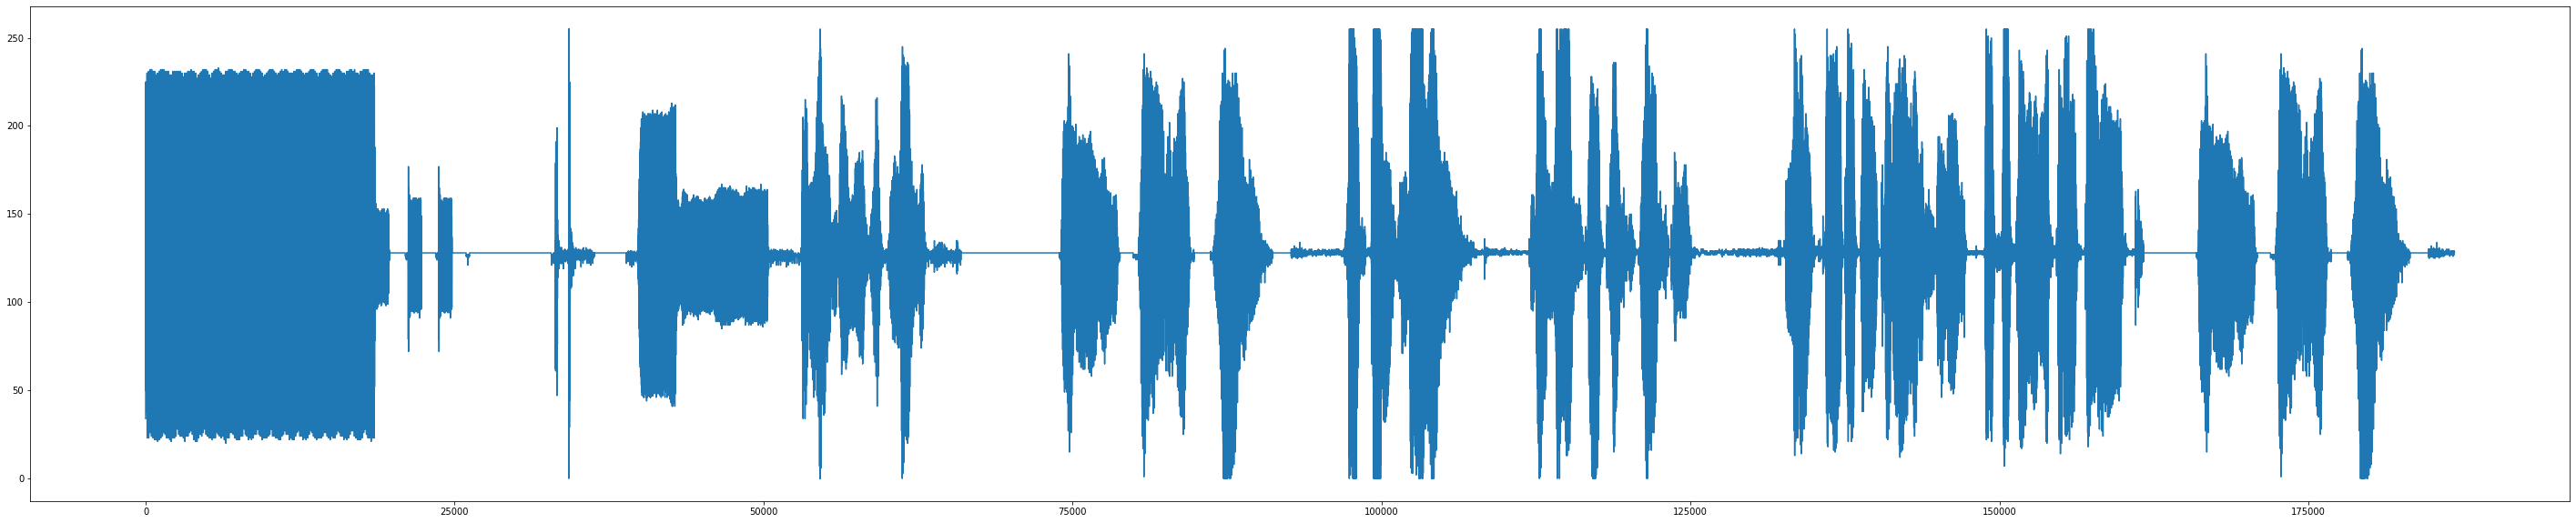

In [171]:
A1 = 1
f1 = 0.1
A2 = 2
f2 = 0.2
Fmax = 3000
wa = 3500

F, x_t = wavfile.read('/test.wav')

with contextlib.closing(wave.open('/test.wav','r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    T = frames / float(rate)
    print("T: ", T)

N = len(x_t)

x_t_2 = copy.deepcopy(x_t)
plt.figure(figsize=(50, 10))
plt.plot(range(N), x_t)

In [172]:
times = [i / F for i in range(N)]

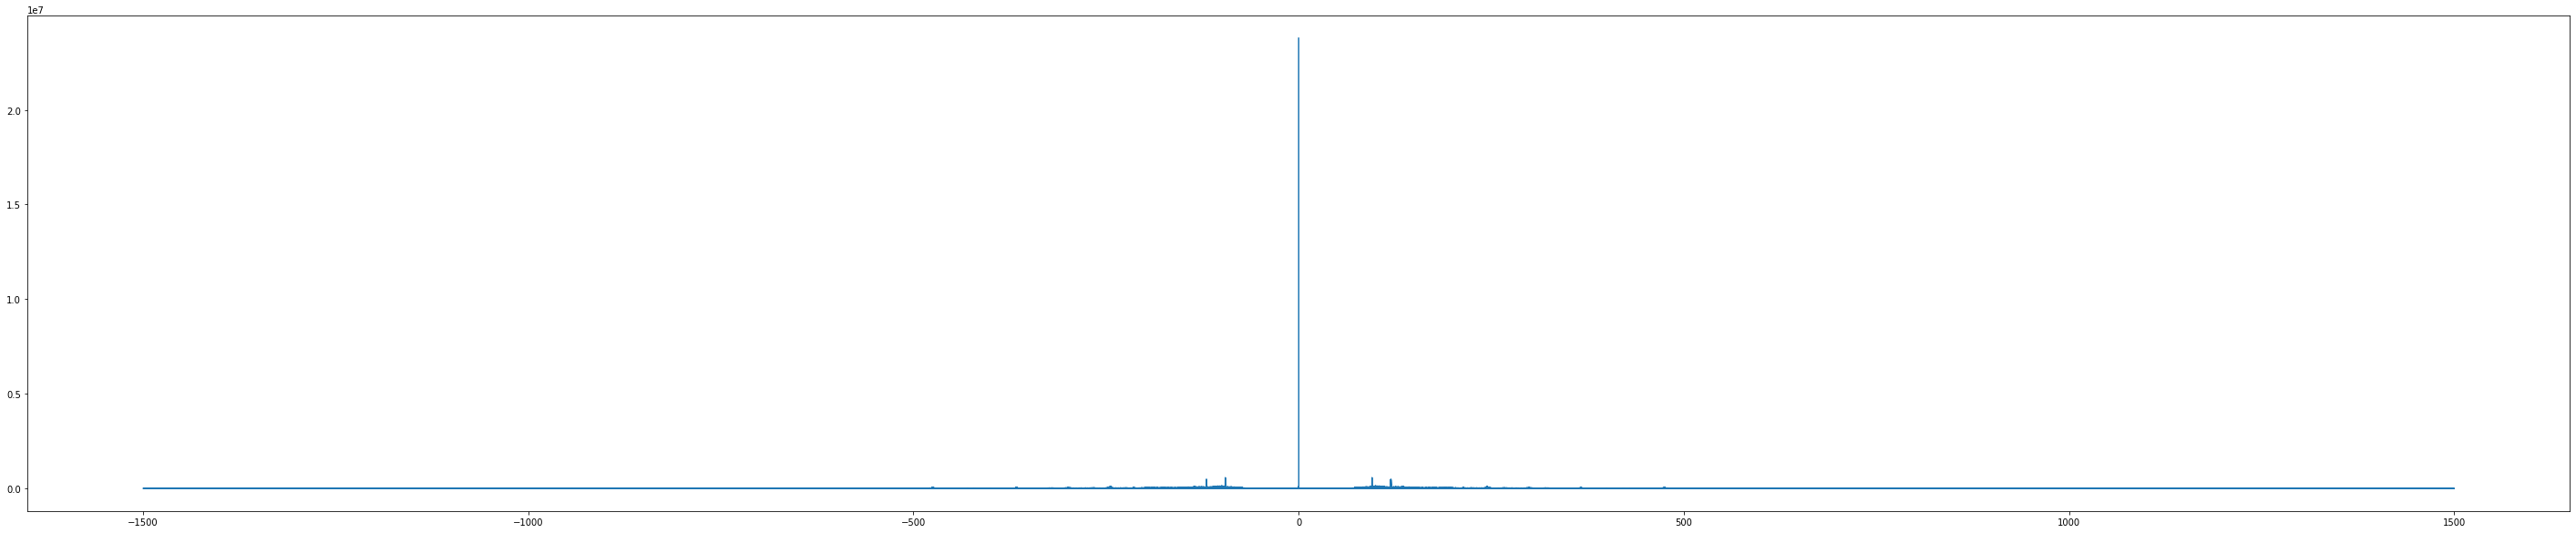

In [173]:
dfp_x = np.fft.fft(x_t)
fk = np.fft.fftfreq(len(dfp_x), d=1/Fmax)
plt.figure(figsize=(50, 10))
plt.plot(fk, abs(dfp_x))

In [174]:
# band-pass на частотах 300-3000 Гц

f1 = 300
f2 = 3000

h_pre = firwin(1111, [f1, f2], fs=F, pass_zero=False)

In [175]:
x_t = np.convolve(x_t, h_pre, mode="same")
x_t_2 = np.convolve(x_t_2, h_pre, mode="same")

In [176]:
Nf = 151
delay = int((Nf-2) / 2)

x_t_2_delay = [0 if i < delay else x_t_2[i - delay] for i in range(N)]

h_rem = -remez(numtaps=Nf, bands=[300, F / 2 - 300], desired=[1], type='hilbert', fs=F)

In [177]:
x_hilb = np.convolve(x_t, h_rem, mode="same")

In [178]:
x_1_filt = [-x_hilb[t] * math.sin(2 * math.pi * times[t] * wa) for t in range(N)]

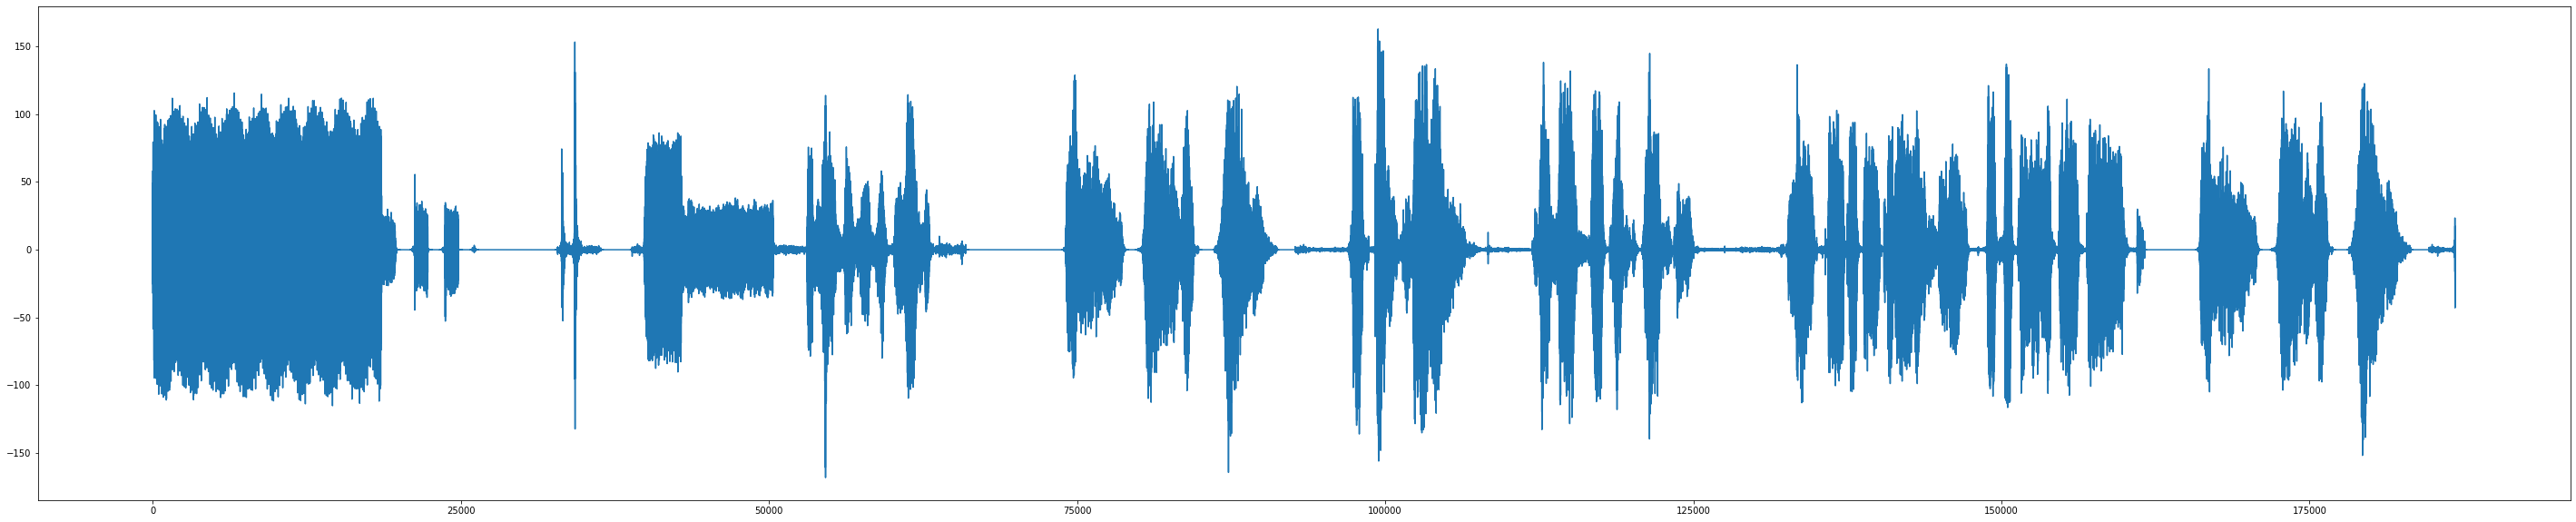

In [179]:
plt.figure(figsize=(50, 10))
plt.plot(range(N), x_1_filt)

In [180]:
x_2_filt = [-x_t_2_delay[t] * math.cos(2 * math.pi * times[t] * wa) for t in range(N)]

In [181]:
y_res = [x_1_filt[t] + x_2_filt[t] for t in range(N)]

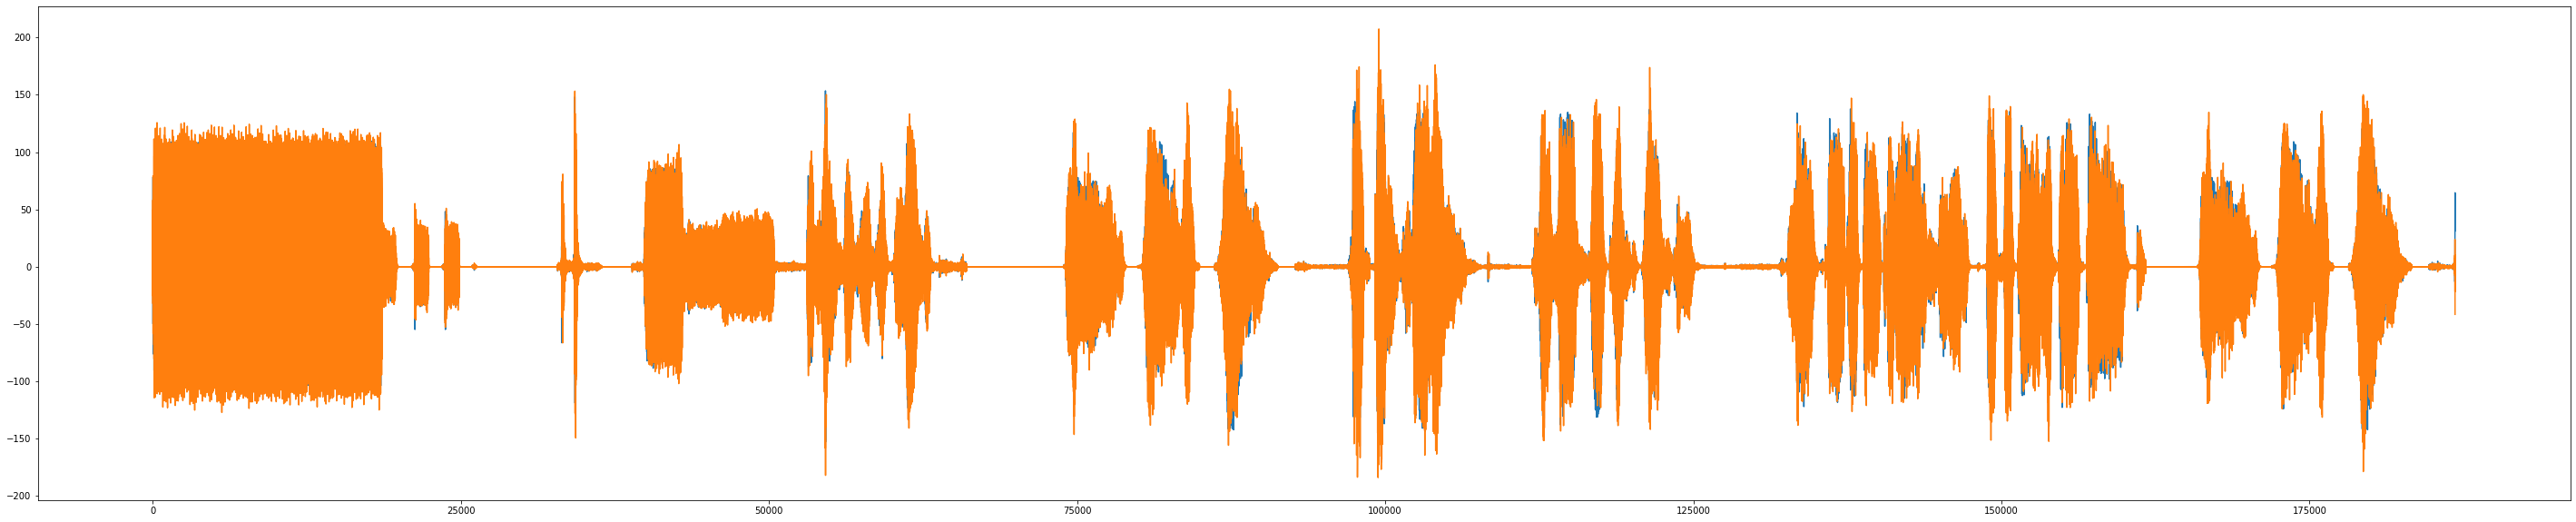

In [182]:
plt.figure(figsize=(50, 10))
plt.plot(range(N), x_t)
plt.plot(range(N), y_res)

In [183]:
y_res_rec = np.float32(y_res)
max_y = max(abs(y_res_rec))
y_res_rec /= max_y

In [184]:
wavfile.write('/test_encoded.wav', F, np.array(y_res_rec))

In [185]:
# декодирование
y_res_2 = copy.deepcopy(y_res)

In [186]:
f1_decode = 500
f2_decode = 3200

h_band_decode = firwin(1111, [f1_decode, f2_decode], fs=F, pass_zero=False)

In [187]:
y_pre_decode = np.convolve(y_res, h_band_decode, mode="same")
y_pre_decode_2 = np.convolve(y_res_2, h_band_decode, mode="same")

In [188]:
Nf = 11
delay = int((Nf-2) / 2)

y_pre_decode_2_delay = [0 if i < delay else y_pre_decode_2[i - delay] for i in range(N)]

In [189]:
h_rem_decode = -remez(numtaps=Nf, bands=[500, F / 2 - 500], desired=[1], type='hilbert', fs=F)

In [190]:
y_dec_hilb = np.convolve(y_pre_decode, h_rem_decode, mode="same")

In [191]:
y_1_filt = [-y_dec_hilb[t] * math.sin(2 * math.pi * times[t] * wa) for t in range(N)]

In [192]:
y_2_filt = [-y_pre_decode_2_delay[t] * math.cos(2 * math.pi * times[t] * wa) for t in range(N)]

In [193]:
y_res_dec = [y_1_filt[t] + y_2_filt[t] for t in range(N)]

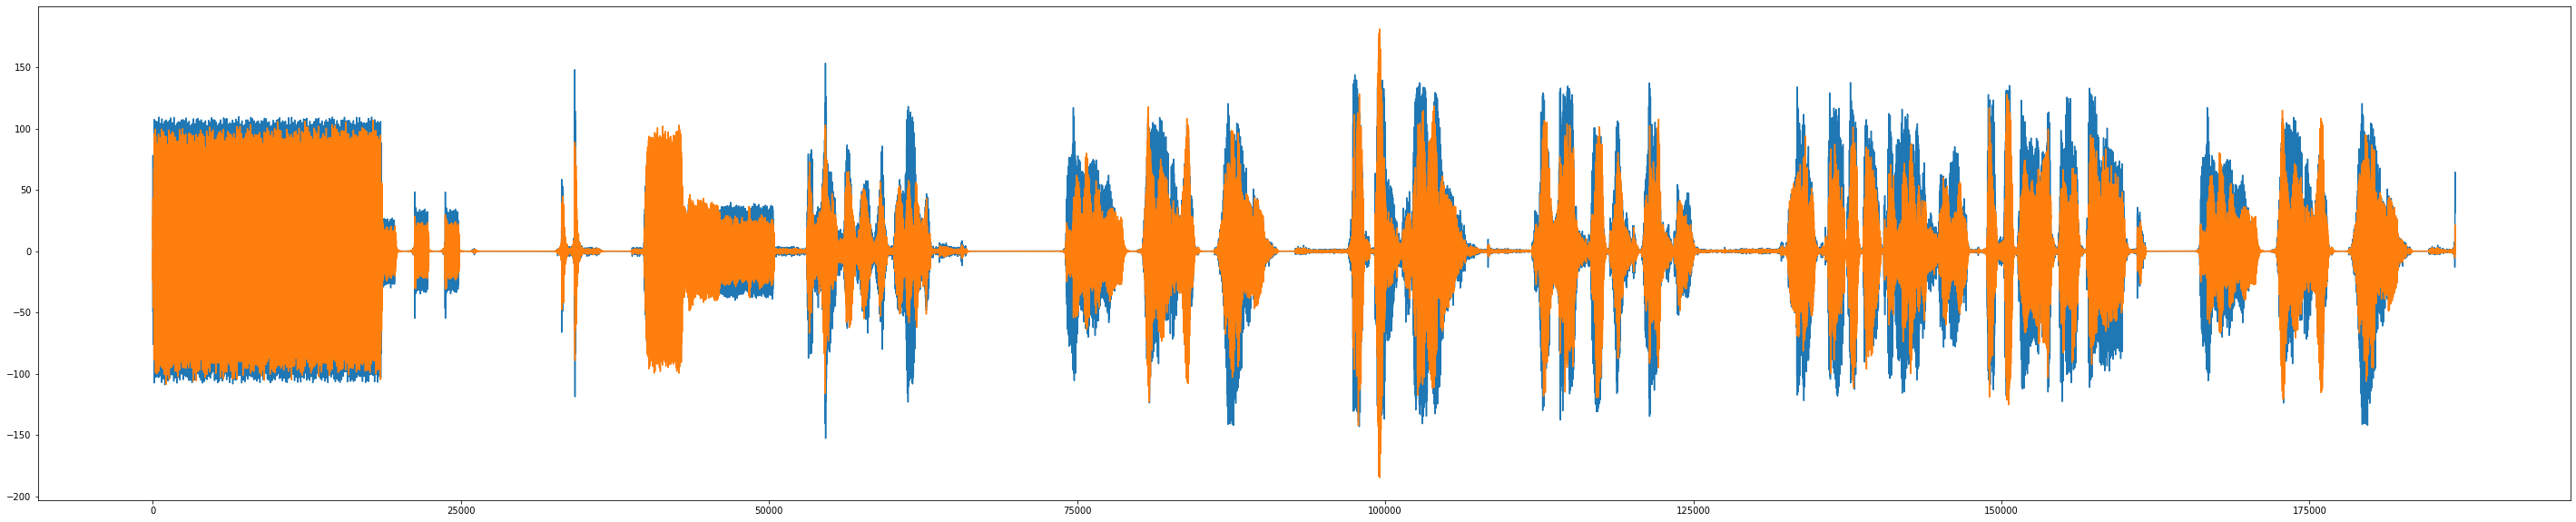

In [194]:
plt.figure(figsize=(50, 10))
plt.plot(range(N), x_t)
plt.plot(range(N), y_res_dec)

In [195]:
y_dec_normed = np.float32(y_res_dec)
max_y_dec = max(abs(y_dec_normed))
y_dec_normed /= max_y_dec

In [196]:
wavfile.write('/test_decoded.wav', F, np.array(y_dec_normed))